In [1]:
import pandas as pd
import numpy as np
import math

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
import shifterator as sh

import nltk
from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import word_tokenize

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-v0_8-whitegrid') # https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
sns.set_style("whitegrid")

LABEL_0 = negative  
LABEL_1 = neutral  
LABEL_2 = positive 

# 1. BERT & R syuzhet

In [ ]:
sentiment_bert_R = pd.read_excel('public_sentiment_bert_syuzhet.xlsx') # from Colab Sentiment_BERT
sentiment_bert_R = sentiment_bert_R[["tweetId", "authorId", 'tweetText', 'created_at', 'retweetCount', 'replyCount',
                                   'likeCount', 'quoteCount', 'impressionCount', 'clean_text', 'lemma_text', 
                                   'bert_text', 'bert_topic_id', 'sentiment_bert', 'sentiment_label']]
sentiment_bert_R = sentiment_bert_R.rename(columns={"sentiment_label": "sentiment_syuzhet"})
sentiment_bert_R

# 2. EKT1
- https://github.com/EKT1/valence

In [16]:
import codecs
import os

with codecs.open("textfile.txt", "w", encoding='utf-8-sig') as temp:
    for text in sentiment_bert_R['bert_text']:
        temp.write(str(text + '\\' + os.linesep))

In [17]:
!python ./valence-master/valencecolor.py textfile.txt

Most Informative Features
                   hästi = True           positi : neutra =     14.4 : 1.0
                     ega = True           negati : neutra =     11.1 : 1.0
             poolfinaali = True           positi : negati =      9.8 : 1.0
                   tugev = True           positi : negati =      9.8 : 1.0
                politsei = True           negati : positi =      9.7 : 1.0
             ääremängija = True           neutra : negati =      9.3 : 1.0
                     hea = True           positi : neutra =      9.1 : 1.0
                koondise = True           positi : negati =      9.0 : 1.0
                    Tähe = True           positi : negati =      8.5 : 1.0
                hariduse = True           positi : negati =      8.5 : 1.0
                  jätkab = True           positi : negati =      8.5 : 1.0
               korvpalli = True           positi : negati =      8.5 : 1.0
                 minutit = True           positi : negati =      8.5 : 1.0

Load corpus: C:\Users\lisannal\OneDrive - Tartu Ülikool\Töölaud\THESIS\MSC-thesis\public_analysis\valence-master\valence\korpus.csv
Train
None


In [18]:
def create_sentiment_label_same_as_bert(array):
    idx = np.array(array).argmax()
    if (idx == 0):
        return 'LABEL_2'
    elif (idx == 1):
        return 'LABEL_0'
    else:
        return 'LABEL_1'

In [19]:
# [positive, negative, neutral]
row_results = []
with open('textfile.txt.html', 'r', encoding='utf-8') as f:

    contents = f.read()

    soup = BeautifulSoup(contents, 'lxml')
    infos = soup.body.find_all('span', {"class": "info"})
    print(len(infos))
    for info in infos:
        text = info.text
        text = text.split('Probability:')[1]
        text = text.replace('positive =', '').replace('negative =', '').replace('neutral =', '').replace('\xa0 ', ' ')
        text = text.split(' ')[1:]
        #print(text)
        row_results.append(create_sentiment_label_same_as_bert(text))

16736


In [20]:
sentiment_bert_R['sentiment_ekt'] = row_results

In [21]:
sentiment_bert_R['sentiment_ekt'].value_counts()

LABEL_0    10535
LABEL_2     5365
LABEL_1      836
Name: sentiment_ekt, dtype: int64

In [22]:
# save file
sentiment_bert_R.to_excel('public_sentiment_bert_syuzhet_ekt.xlsx', index = False)

# Majority voting

In [24]:
# https://stackoverflow.com/questions/43990485/set-pandas-dataframe-winner-column-value-based-on-majority-value-from-three-othe

mostCommonVote = []
for row in sentiment_bert_R[['sentiment_bert','sentiment_ekt','sentiment_syuzhet']].values:
    num_values = [int(value.split('_')[1]) for value in row]
    #average_label = round(np.sum(num_values) / len(row))
    mode_label = max(set(num_values), key=num_values.count)
    if len(set(num_values)) == 3: # if 3 different values, then neutral
        mode_label = 1
    mostCommonVote.append('LABEL_' + str(mode_label))

sentiment_bert_R['winner'] = mostCommonVote

In [ ]:
sentiment_bert_R.head()

In [27]:
sentiment_bert_R['winner'].value_counts()

LABEL_0    8135
LABEL_1    7121
LABEL_2    1480
Name: winner, dtype: int64

# Topics to sentiments df

In [28]:
sentiments_topics = sentiment_bert_R.copy()

In [29]:
sentiments_topics['bert_topic_id'].unique()

array(['War', 'Russia', 'Estonia', 'Nuclear', 'Gas', 'Education',
       'News/Social Media', 'Women', 'Refugees', 'Combat', 'Sanctions',
       'Donations', 'Eurovision', 'Flag & Colors', 'Sports'], dtype=object)

In [30]:
# rename 'winner' to 'sentiment'
sentiments_topics = sentiments_topics.rename(columns={"winner": "sentiment"})

# rename values in 'sentiment' column
sentiments_topics['sentiment'] = sentiments_topics['sentiment'].replace(['LABEL_0', 'LABEL_1', 'LABEL_2'],
                                                           ['negative', 'neutral', 'positive'])

In [ ]:
# create a new column with month and year combined
sentiments_topics['created_at'] = pd.to_datetime(sentiments_topics['created_at'])

sentiments_topics['month_year'] = sentiments_topics['created_at'].dt.strftime('%b%y')
sentiments_topics

In [183]:
sentiments_topics['bert_topic_id'] = sentiments_topics['bert_topic_id'].replace(['Gas'],
                                                           ['Energy Security'])

In [186]:
sentiments_topics['bert_topic_id'].value_counts()

Russia               5235
Estonia              4248
War                  2710
News/Social Media    1021
Combat                660
Refugees              427
Energy Security       409
Donations             385
Eurovision            355
Education             304
Nuclear               299
Women                 240
Sanctions             188
Flag & Colors         138
Sports                117
Name: bert_topic_id, dtype: int64

In [33]:
# save file
from datetime import datetime, timezone
sentiments_topics['created_at'] = sentiments_topics['created_at'].dt.tz_localize(None)
sentiments_topics.to_excel('sentiments_topics.xlsx', index = False)

In [160]:
sentiments_topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16736 entries, 0 to 16735
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   tweetId            16736 non-null  int64         
 1   authorId           16736 non-null  int64         
 2   tweetText          16736 non-null  object        
 3   created_at         16736 non-null  datetime64[ns]
 4   retweetCount       16736 non-null  int64         
 5   replyCount         16736 non-null  int64         
 6   likeCount          16736 non-null  int64         
 7   quoteCount         16736 non-null  int64         
 8   impressionCount    16736 non-null  int64         
 9   clean_text         16736 non-null  object        
 10  lemma_text         16736 non-null  object        
 11  bert_text          16736 non-null  object        
 12  bert_topic_id      16736 non-null  category      
 13  sentiment_bert     16736 non-null  object        
 14  sentim

# Topics x sentiment Analysis

## Frequency of positive, negative and neutral posts

In [34]:
# overall sentiment classes
sentiments_topics['sentiment'].value_counts()

negative    8135
neutral     7121
positive    1480
Name: sentiment, dtype: int64

In [169]:
timeline = sentiments_topics[['month_year']]
timeline = timeline.groupby('month_year')
#timeline = timeline.reset_index(name='count')

#timeline = timeline.pivot(index='month_year', values='count')
timeline = timeline.value_counts()
timeline = pd.DataFrame(timeline)
order= ['Jan22', 'Feb22', 'Mar22', 'Apr22', 'May22', 'Jun22', 'Jul22', 'Aug22', 'Sep22', 'Oct22', 'Nov22',
                      'Dec22','Jan23']
timeline = timeline.reindex(order)
timeline = timeline.rename(columns={0: "count"})

timeline

,count
month_year,
Jan22,191
Feb22,1739
Mar22,3476
Apr22,1841
May22,1455
Jun22,768
Jul22,697
Aug22,948
Sep22,1099


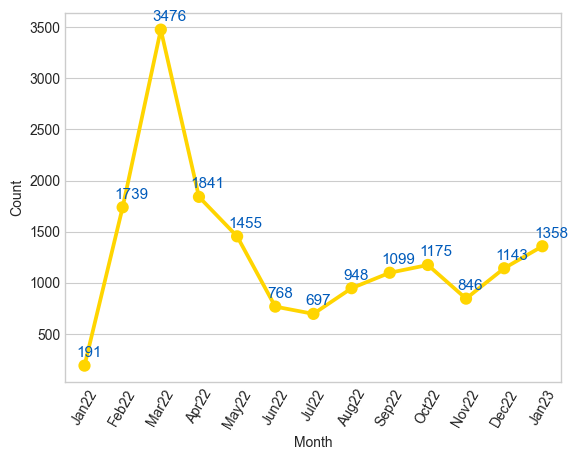

In [181]:
ax = sns.pointplot(data=timeline, x = timeline.index, y = 'count', color = '#FFD500')

[ax.text(p[0]- 0.22, p[1] + 85, p[1], color='#005BBB', size=11) for p in zip(ax.get_xticks(), timeline['count'])]


plt.xticks(rotation=60)
plt.xlabel("Month")
plt.ylabel("Count")

plt.savefig('leaders_timeline', facecolor=fig.get_facecolor(), bbox_inches='tight')

plt.show()

In [35]:
# posts per month

placeholder = sentiments_topics[['created_at']]
placeholder = placeholder.groupby(pd.Grouper(key='created_at', freq='1M')).size() # groupby each 1 month
placeholder.index = placeholder.index.strftime('%B')
placeholder

created_at
January       191
February     1739
March        3476
April        1841
May          1455
June          768
July          697
August        948
September    1099
October      1175
November      846
December     1143
January      1358
dtype: int64

In [188]:
# sentiment freqs per month 
sentiments_topics['created_at'] = sentiments_topics['created_at'].apply(pd.to_datetime)

label_counts = sentiments_topics.groupby([pd.Grouper(key='created_at', freq='1M'), 'sentiment']).size()
label_counts = label_counts.reset_index(name='count')

label_counts = label_counts.pivot(index='created_at', columns='sentiment', values='count')

label_counts.index = label_counts.index.strftime('%B')
label_counts.index = ['Jan22', 'Feb22', 'Mar22', 'Apr22', 'May22', 'Jun22', 'Jul22', 'Aug22', 'Sep22', 'Oct22', 'Nov22',
                      'Dec22','Jan23']
label_counts

sentiment,negative,neutral,positive
Jan22,97,77,17
Feb22,821,764,154
Mar22,1665,1528,283
Apr22,941,770,130
May22,654,656,145
Jun22,365,335,68
Jul22,362,286,49
Aug22,479,392,77
Sep22,564,460,75
Oct22,631,439,105


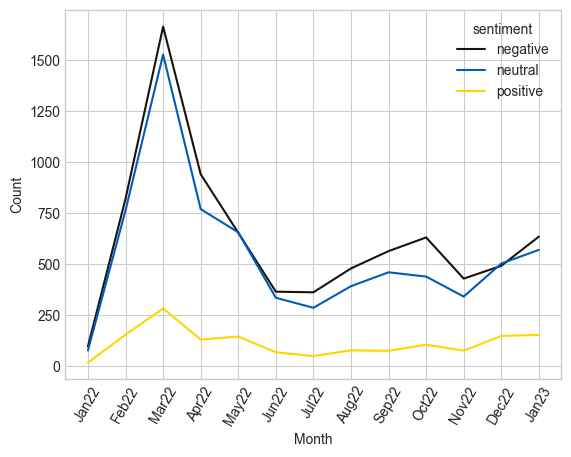

In [190]:
custom_palette = ["#1A120B", "#005BBB", '#FFD500'] # black, blue, yellow

sns.lineplot(data=label_counts, dashes=False, palette=custom_palette)
plt.xticks(rotation=60)
plt.xlabel("Month")
plt.ylabel("Count")

plt.savefig('public_sentiment_timeline', facecolor=fig.get_facecolor(), bbox_inches='tight')

plt.show()

In [595]:
#time_data['week_interval'] = time_data.groupby(pd.Grouper(key='created_at', freq='W'))['created_at'].transform('first')
sentiments_topics['week'] = sentiments_topics['created_at'].dt.strftime('%G_%V')
#time_data['week'] = time_data['created_at'].dt.strftime('%U-%Y')
sentiments_topics['week'] = pd.Categorical(sentiments_topics['week'], 
                                           categories=sentiments_topics['week'].unique().sort(), ordered=True)
sentiments_topics = sentiments_topics[(sentiments_topics['week']!='2021_52')] 

sentiments_topics

C:\Users\lisannal\AppData\Local\Temp\ipykernel_1648\1257316222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiments_topics['week'] = sentiments_topics['created_at'].dt.strftime('%G_%V')
C:\Users\lisannal\AppData\Local\Temp\ipykernel_1648\1257316222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiments_topics['week'] = pd.Categorical(sentiments_topics['week'],


,tweetId,authorId,tweetText,created_at,retweetCount,replyCount,likeCount,quoteCount,impressionCount,clean_text,lemma_text,bert_text,bert_topic_id,sentiment_bert,sentiment_syuzhet,sentiment_ekt,sentiment,month_year,week
0,1618269083782491904,4162321575,"Ei Ants! Gerassimov on oma tegevusega samasugune kurikael ja mõrtsukas, nagu ""hunta"" ja ""kagebiidid"". ""Ülema vastutuse"" doktriin teda ei päästa. Pigem vastupidi - seob teda vastutusega veelgi enam. Ja kui sinu normaalsus on agressioon ja mõrvad, siis ..._x000D_\nhttps://t.co/gIDSVqvdUn",2023-01-25 15:26:30,0,10,84,0,8005,gerassimov tegevusega kurikael mõrtsukas hunta kagebiidid ülema vastutuse doktriin päästa vastupidi seob vastutusega normaalsus agressioon mõrvad,gerassimov tegevus kurikael mõrtsukas hunta kagebiid ülem vastutus doktriin päästma vastupidi siduma vastutus normaalsus agressioon mõrv,"ei ants! gerassimov oma tegevusega samasugune kurikael mõrtsukas, nagu "" hunta "" "" kagebiidid "". "" ülema vastutuse "" doktriin teda ei päästa. pigem vastupidi - seob teda vastutusega veelgi. ja kui sinu normaalsus agressioon mõrvad, siis...",War,LABEL_0,LABEL_1,LABEL_0,negative,Jan23,2023_04
1,1613567957447373056,246073083,"Ükskõik kui palju Putin sissetungi õigustaks, vead paljastatakse... tõend, et agressioon oli vale!_x000D_\nhttps://t.co/rMWmsRJOO7",2023-01-12 16:05:54,0,0,0,0,3,sissetungi õigustaks vead paljastatakse tõend agressioon,sissetung õigustama viga paljastama tõend agressioon,"ükskõik kui palju putin sissetungi õigustaks, vead paljastatakse... tõend, agressioon oli!",Russia,LABEL_0,LABEL_1,LABEL_0,negative,Jan23,2023_02
2,1613526286093147904,1599927379140435968,"Vene agressioon on toonud kaasa Eesti viisade taotlemise ja suurema kontrolli, et vältida Venemaa relvastatud konflikte meie riigiga. See on murettekitav, kuid me peame olema tugevad ja püsima kindlalt. https://t.co/8Q11RRRTFE",2023-01-12 13:20:19,0,0,0,0,4,vene agressioon toonud kaasa eesti viisade taotlemise suurema kontrolli vältida venemaa relvastatud konflikte riigiga murettekitav tugevad püsima kindlalt,vene agressioon tooma kaasa eesti viisa taotlemine suurem kontroll vältima venemaa relvastatud konflikt riik murettekitav tugev püsima kindlalt,"vene agressioon toonud kaasa eesti viisade taotlemise suurema kontrolli, vältida venemaa relvastatud konflikte meie riigiga. see murettekitav, kuid peame olema tugevad püsima kindlalt.",Estonia,LABEL_2,LABEL_1,LABEL_0,neutral,Jan23,2023_02
3,1613112158123953920,843358862,"""Hiinale oleks meelepärane, kui Venemaad saadaks Ukrainas sõjaline edu, sest Hiina peab Venemaa julgeolekuhuvisid Ukrainas (ja ka laiemalt Ida-Euroopas) legitiimseteks,"" kirjutab @ICDS_Tallinn nooremteadur Rüüt Kaljula. Loe artiklit:_x000D_\nhttps://t.co/UWUZyuCCtW",2023-01-11 09:54:43,1,0,3,0,251,hiinale meelepärane venemaad ukrainas sõjaline edu hiina venemaa julgeolekuhuvisid ukrainas laiemalt idaeuroopas legitiimseteks kirjutab nooremteadur rüüt kaljula loe artiklit,hiina meelepärane venemaa ukraina sõjaline edu hiina venemaa julgeolekuhuvi ukraina laiemalt idaeuroobas legitiimne kirjutama nooremteadur rüüt kaljula lugema artikkel,""" hiinale oleks meelepärane, kui venemaad saadaks ukrainas sõjaline edu, sest hiina peab venemaa julgeolekuhuvisid ukrainas (laiemalt - euroopas) legitiimseteks,"" kirjutab nooremteadur rüüt kaljula. loe artiklit:",Russia,LABEL_0,LABEL_1,LABEL_0,negative,Jan23,2023_02
4,1613097925781126912,1448182496,"_x000D_\n_x000D_\nHeino Enden väga tabavalt Betsafe LIVE podcastis:_x000D_\n_x000D_\n“See ei ole nagu Levadia-Flora mäng, kus võid jääda erapooletuks, võtad õlut, paned viina, räägid sõbraga juttu - vahet pole. See on sõda. Terrorism. Agressioon. Kui sa siin poolt ei vali, siis on selge, kelle poolt sa oled.” https://t.co/GNmq8cZAtK",2023-01-11 08:58:10,37,2,298,4,25043,heino enden tabavalt betsafe podcastissee levadiaflora mäng jääda erapooletuks võtad õlut viina räägid sõbraga juttu vahet sõda agressioon selge,heino enden tabavalt betsafe podcastissee 

In [596]:
label_counts = sentiments_topics.groupby(['week','sentiment']).size()
label_counts = label_counts.reset_index(name='count')

label_counts = label_counts.pivot(index='week', columns='sentiment', values='count')

label_counts

sentiment,negative,neutral,positive
week,,,
2022_01,8,10,3
2022_02,16,14,3
2022_03,29,26,6
2022_04,37,23,5
2022_05,24,16,6
2022_06,39,27,7
2022_07,82,88,12
2022_08,573,532,111
2022_09,597,584,101


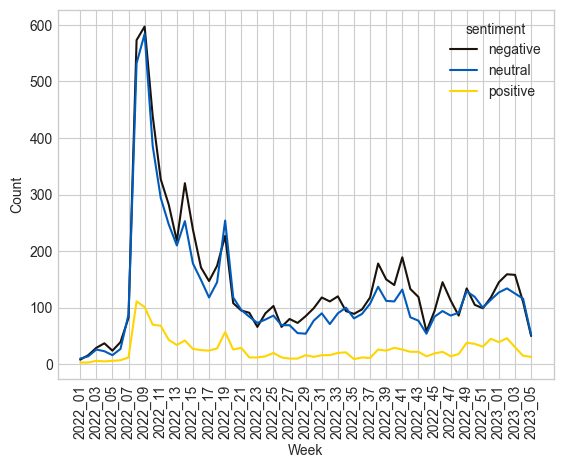

In [662]:
custom_palette = ["#1A120B", "#005BBB", '#FFD500'] # black, blue, yellow

plot = sns.lineplot(data=label_counts, dashes=False, palette=custom_palette)

plot.set_xticks(plot.get_xticks()[::2])
plt.xticks(rotation=90)
plt.xlabel("Week")
plt.ylabel("Count")

figure_width = 1.89  # cm to inches: 1.89 / 2.54
figure_height = 1.57  # cm to inches: 1.57 / 2.54
fig.set_size_inches(figure_width, figure_height)

dpi = 300  
plt.savefig('public_sentiment_timeline_weeks', facecolor=fig.get_facecolor(), bbox_inches='tight', dpi=dpi)

plt.show()

## Visualize sentiment per topic

In [182]:
sentiments_topics['bert_topic_id'].value_counts()

Russia               5235
Estonia              4248
War                  2710
News/Social Media    1021
Combat                660
Refugees              427
Gas                   409
Donations             385
Eurovision            355
Education             304
Nuclear               299
Women                 240
Sanctions             188
Flag & Colors         138
Sports                117
Name: bert_topic_id, dtype: int64

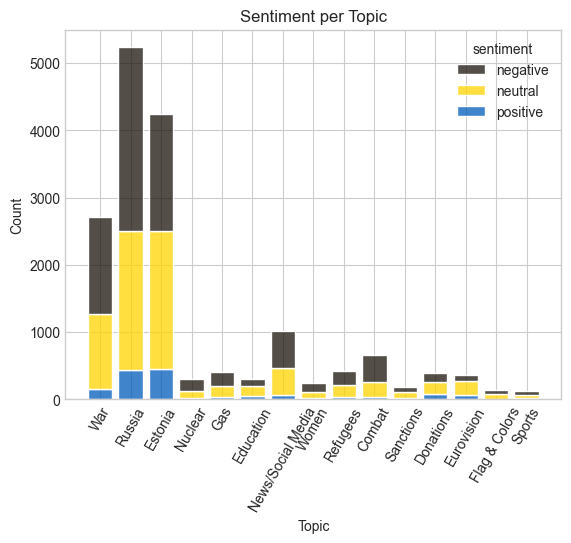

In [39]:
# pos, neg, neutral posts per topic

sns.histplot(sentiments_topics, x="bert_topic_id", hue="sentiment",
             multiple='stack', palette= [custom_palette[0], custom_palette[2], custom_palette[1]], shrink=0.8)

plt.xticks(rotation=60)
plt.title("Sentiment per Topic")
plt.xlabel("Topic")
plt.ylabel("Count")

plt.show()

# ISSUES
# värvid legendil valesti, st ukr lipp ei tule

In [ ]:
negatives = sentiments_topics[sentiments_topics['sentiment'] == 'negative']['bert_topic_id'].value_counts()
negatives = negatives.rename('negative')
totals = sentiments_topics['bert_topic_id'].value_counts()
totals = totals.rename('total')
combined = pd.concat([negatives, totals], axis=1).reset_index()

proportions = []
for idx,row in combined.iterrows():
    proportions.append(row['negative'] / row['total'])
    
combined['proportions'] = proportions
combined = combined.sort_values(by=['proportions'], ascending=False)
label_order = list(combined['index'])

sentiments_topics["bert_topic_id"] = pd.Categorical(sentiments_topics["bert_topic_id"], categories = label_order)
sentiments_topics.sort_values('bert_topic_id')

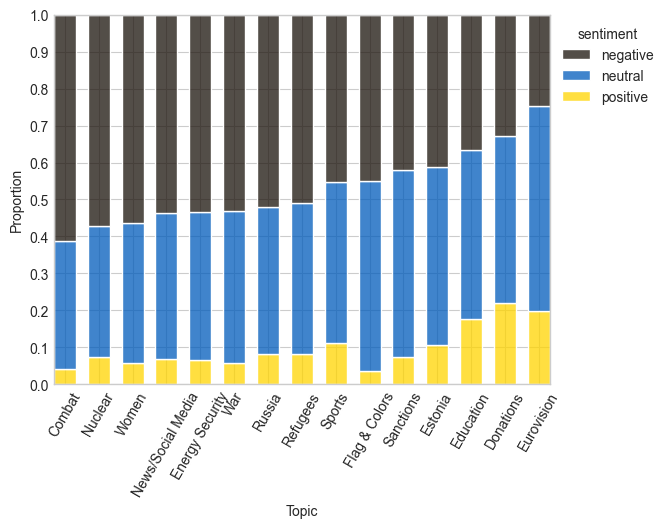

In [209]:
hist = sns.histplot(sentiments_topics, x="bert_topic_id", hue="sentiment", stat="proportion", discrete=True,
             multiple='fill', palette = [custom_palette[0], custom_palette[1], custom_palette[2]], shrink=0.65)


sns.move_legend(hist, "upper left", bbox_to_anchor=(1, 1))
plt.yticks(np.arange(0.0, 1.1, 0.1))

plt.xticks(rotation=60)
#plt.title("Sentiment per Topic")
plt.xlabel("Topic")
#plt.ylabel("Count")

plt.savefig('public_sentiment_topics', facecolor=fig.get_facecolor(), bbox_inches='tight')

plt.show()

## Visualize sentiment per topic per month

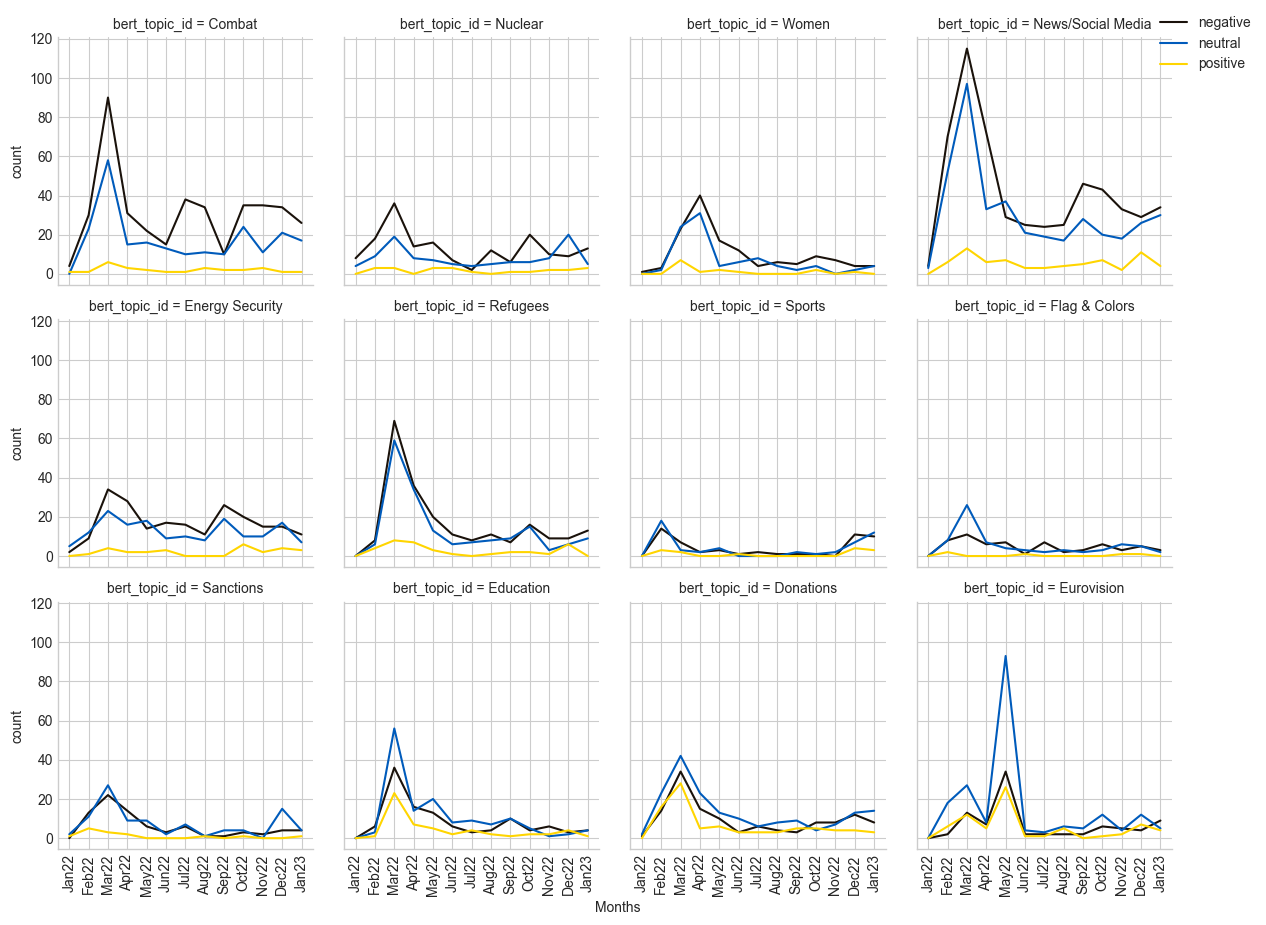

In [231]:
from pandas.api.types import CategoricalDtype

label_counts = sentiments_topics.groupby(['bert_topic_id','month_year', 'sentiment']).size()
label_counts = label_counts.reset_index(name='count')

order = ['Jan22', 'Feb22', 'Mar22', 'Apr22', 'May22', 'Jun22', 'Jul22', 'Aug22', 'Sep22', 'Oct22', 'Nov22', 'Dec22','Jan23']

label_counts['month_year'] = label_counts['month_year'].astype(CategoricalDtype(categories=order, ordered=True))
label_counts = label_counts.sort_values('month_year')

label_counts = label_counts[label_counts['bert_topic_id'] != 'Russia']
label_counts = label_counts[label_counts['bert_topic_id'] != 'Estonia']
label_counts = label_counts[label_counts['bert_topic_id'] != 'War']
label_counts['bert_topic_id'] = label_counts['bert_topic_id'].cat.remove_unused_categories()
label_counts['sentiment'] = label_counts['sentiment'].astype('category')

# facet grid
g = sns.FacetGrid(data=label_counts, col="bert_topic_id", col_wrap=4, legend_out=False)

# lineplot
g.map_dataframe(sns.lineplot, x="month_year", y="count", hue = 'sentiment', dashes=False, 
                palette=[custom_palette[0], custom_palette[1], custom_palette[2]])
g.set(xlabel=None)
#g.set(ylabel=None)
g.fig.text(0.5, -0.01, 'Months')
#g.fig.text(0.5, -0.03, 'tim')


g.add_legend()
sns.move_legend(g, "upper left", bbox_to_anchor=(0.96, 1))

[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

plt.savefig('public_sentiment_topics_months', facecolor=fig.get_facecolor(), bbox_inches='tight')

plt.show()

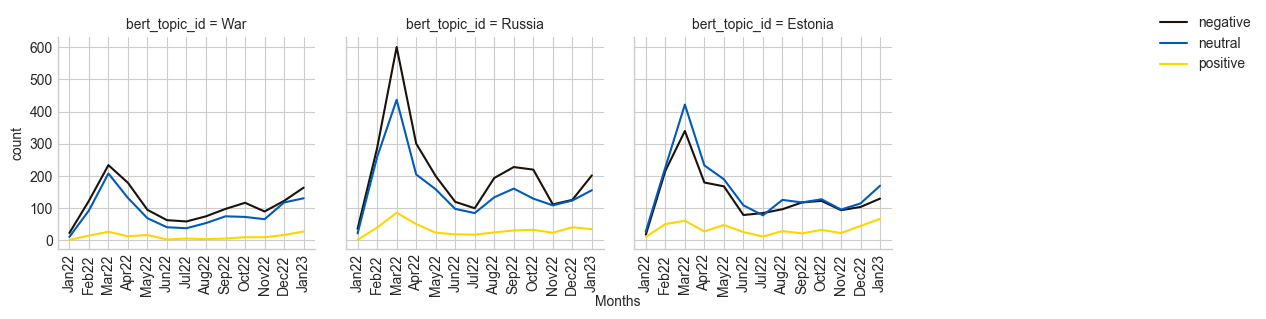

In [230]:
from pandas.api.types import CategoricalDtype

label_counts = sentiments_topics.groupby(['bert_topic_id','month_year', 'sentiment']).size()
label_counts = label_counts.reset_index(name='count')

order = ['Jan22', 'Feb22', 'Mar22', 'Apr22', 'May22', 'Jun22', 'Jul22', 'Aug22', 'Sep22', 'Oct22', 'Nov22', 'Dec22','Jan23']

label_counts['month_year'] = label_counts['month_year'].astype(CategoricalDtype(categories=order, ordered=True))
label_counts = label_counts.sort_values('month_year')

label_counts = label_counts[label_counts['bert_topic_id'].isin(['Russia', 'Estonia', 'War'])]
label_counts['bert_topic_id'] = label_counts['bert_topic_id'].cat.remove_unused_categories()
label_counts['sentiment'] = label_counts['sentiment'].astype('category')

# facet grid
g = sns.FacetGrid(data=label_counts, col="bert_topic_id", col_wrap=4, legend_out=False)

# lineplot
g.map_dataframe(sns.lineplot, x="month_year", y="count", hue = 'sentiment', dashes=False, 
                palette=[custom_palette[0], custom_palette[1], custom_palette[2]])
g.set(xlabel=None)
#g.set(ylabel=None)
g.fig.text(0.5, -0.01, 'Months')
#g.fig.text(0.5, -0.03, 'tim')


g.add_legend()
sns.move_legend(g, "upper left", bbox_to_anchor=(0.96, 1))

[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

plt.savefig('public_sentiment_topics_months_2', facecolor=fig.get_facecolor(), bbox_inches='tight')

plt.show()

## Top3 topics per month

In [288]:
filter_out_top_3 = sentiments_topics[~sentiments_topics['bert_topic_id'].isin(['Russia', 'Estonia', 'War'])]
topTopicsPerMonth = (filter_out_top_3.groupby(['month_year', 'bert_topic_id']).size() 
   .sort_values(ascending=False) 
   .reset_index(name='count') )

n_largest = 3
order = ['Jan22', 'Feb22', 'Mar22', 'Apr22', 'May22', 'Jun22', 'Jul22', 'Aug22', 'Sep22', 'Oct22', 'Nov22', 'Dec22','Jan23']
topTopicsPerMonth['month_year'] = pd.Categorical(topTopicsPerMonth['month_year'], categories=order, ordered=True)


top3_per_month = (topTopicsPerMonth.groupby(['month_year', 'bert_topic_id'])
                 .sum()
                 .reset_index()
                 .sort_values(['month_year', 'count'], ascending=[True, False])
                 .groupby('month_year')
                 .head(n_largest))
top3_per_month

,month_year,bert_topic_id,count
6,Jan22,Russia,60
11,Jan22,Estonia,57
5,Jan22,War,36
21,Feb22,Russia,586
26,Feb22,Estonia,494
20,Feb22,War,231
36,Mar22,Russia,1124
41,Mar22,Estonia,823
35,Mar22,War,469
51,Apr22,Russia,557


# Compare negative sentiment posts vs positive sentiment posts

## sentiments of top n words

In [512]:
# initialize CounVectorizer
def create_term_matrix(in_data):
    cv = CountVectorizer(analyzer = 'word')
    data = cv.fit_transform(in_data['lemma_text'])
    tm_matrix = pd.DataFrame(data.toarray(), columns = cv.get_feature_names_out())
    tm_matrix.index = in_data.index
    return tm_matrix.sum().transpose()

In [513]:
# print top15 words
topn_words = create_term_matrix(sentiments_topics)
topn_words = pd.DataFrame(topn_words.items(), columns=['word', 'n'])
topn_words.sort_values(by='n', ascending=False).head(15)

,word,n
27940,ukraina,10740
29632,venemaa,7553
24432,sõda,2736
3218,eesti,1974
29598,vene,1540
21533,riik,1247
6870,inimene,1053
37,aasta,757
4425,euroopa,746
32199,ütlema,745


In [55]:
words_to_search = ['ukraina', 'eesti', 'venemaa', 'euroopa', 'sõda', 'inimene']
result = {}
for search_word in words_to_search:
    result[search_word] = {
        "positive": 0,
        "negative": 0,
        "neutral": 0,
    }
    
for idx, row in sentiments_topics.iterrows():
    text = row['lemma_text']
    sentiment = row['sentiment']
    for word in words_to_search:
        count = text.count(word)
        if count != 0:
            result[word][sentiment] = result[word][sentiment] + 1
result    

{'ukraina': {'positive': 1052, 'negative': 4553, 'neutral': 4491},
 'eesti': {'positive': 304, 'negative': 965, 'neutral': 1009},
 'venemaa': {'positive': 404, 'negative': 3734, 'neutral': 2679},
 'euroopa': {'positive': 92, 'negative': 318, 'neutral': 389},
 'sõda': {'positive': 197, 'negative': 1401, 'neutral': 1002},
 'inimene': {'positive': 81, 'negative': 585, 'neutral': 314}}

In [56]:
result = pd.DataFrame(result.items())
result = pd.json_normalize(result.to_dict(orient='records'))
result = pd.melt(result, id_vars=[0], value_vars=['1.positive', '1.negative', '1.neutral'], var_name='sentiment')
result['sentiment'] = result['sentiment'].str.split('.').str[1]  # extract the sentiment name from the column name
result.columns = ['word', 'sentiment', 'count']
result = result.loc[result.index.repeat(result['count'])].assign(count_new=1).reset_index(drop=True)

In [57]:
result

,word,sentiment,count,count_new
0,ukraina,positive,1052,1
1,ukraina,positive,1052,1
2,ukraina,positive,1052,1
3,ukraina,positive,1052,1
4,ukraina,positive,1052,1
...,...,...,...,...
23565,inimene,neutral,314,1
23566,inimene,neutral,314,1
23567,inimene,neutral,314,1
23568,inimene,neutral,314,1


In [58]:
# sorting
negatives = result[result['sentiment'] == 'negative']['word'].value_counts()
negatives = negatives.rename('negative')
totals = result['word'].value_counts()
totals = totals.rename('total')
combined = pd.concat([negatives, totals], axis=1).reset_index()

proportions = []
for idx,row in combined.iterrows():
    proportions.append(row['negative'] / row['total'])
    
combined['proportions'] = proportions
combined = combined.sort_values(by=['proportions'], ascending=False)
label_order = list(combined['index'])

result["word"] = pd.Categorical(result["word"], categories = label_order)
result.sort_values('word')

,word,sentiment,count,count_new
23569,inimene,neutral,314,1
13244,inimene,negative,585,1
13243,inimene,negative,585,1
13242,inimene,negative,585,1
13241,inimene,negative,585,1
...,...,...,...,...
11431,euroopa,negative,318,1
11430,euroopa,negative,318,1
11429,euroopa,negative,318,1
11427,euroopa,negative,318,1


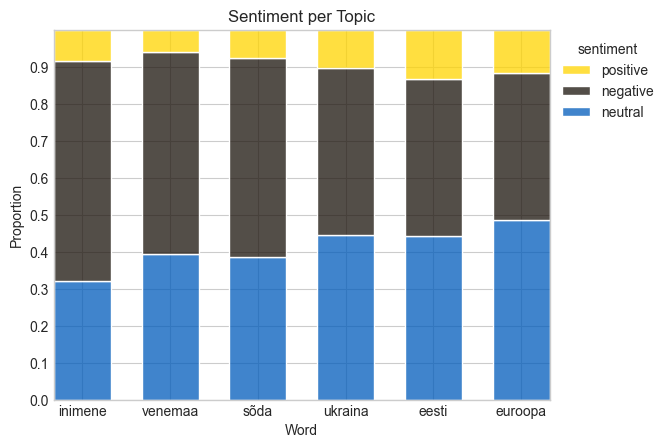

In [59]:
hist = sns.histplot(result, x="word", hue="sentiment", stat="proportion", discrete=True,
             multiple='fill', palette = [custom_palette[2], custom_palette[0], custom_palette[1]], shrink=0.65)


sns.move_legend(hist, "upper left", bbox_to_anchor=(1, 1))

#plt.xticks(rotation=60)
plt.title("Sentiment per Topic")
plt.xlabel("Word")
#plt.ylabel("Count")

plt.yticks(np.arange(0, 1, 0.1))

plt.show()

# sorteerida desc pos
# % joonisele?

## wordshift comparison negative vs positive dfs

In [289]:
# subset data
neg_df = sentiments_topics[sentiments_topics["sentiment"] == 'negative'] 
pos_df = sentiments_topics[sentiments_topics["sentiment"] == 'positive'] 
print('neg_df', len(neg_df))
print('pos_df', len(pos_df))

# get terms and counts
term_neg = create_term_matrix(neg_df).sort_values(ascending=False)
term_pos = create_term_matrix(pos_df).sort_values(ascending=False)

# pandas series to to dict
from collections import OrderedDict, defaultdict

term_neg = term_neg.to_dict()
term_pos = term_pos.to_dict()

neg_df 8135
pos_df 1480


In [297]:
my_dict = {
    "vene": "russian",
    "eesti": "estonia",
    "venemaa": "russia",
    "ukraina": "ukraine",
    "oluline": "important",
    "täna": "today",
    "koostöö": "cooperation",
    "euroopa": "europe",
    "toetama": "need to support",
    "inimene": "people",
    "lihtsalt": "simply",
    "julgeolek": "security",
    "toetus": "support",
    "toetama": "to support",
    "elama": "to live",
    "samm": "step",
    "andma": "to give",
    "venelane": "russian person",
    "hea": "good",
    "võitma": "to win",
    "ekre": "ekre",
    "võimalus": "opportunity",
    "aitama": "to help",
    "võit": "win",
    "annetama": "to donate",
    "ütlema": "to say",
    "vaba": "free",
    "parim": "best",
    "tugev": "strong",
    "valmis": "ready",
    "putin": "putin",
    "hästi": "well",
    "parem": "better",
    "tahtma": "to want",
    "aeg": "time",
    "abi": "help",
    "jääma": "to stay",
    "kaotama": "to lose",
    "kaasa": "with",
    "aasta": "year",
    "annetus": "donation",
    "soovitama": "to recommend",
    "päev": "day",
    "suurepärane": "excellent",
    "näitama": "to show",
    "lootma": "to hope",
    "tubli": "fine",     #####
    "koguma": "to collect",
    "uus": "new",
    "sõda": "war",
    "pakkuma":"to offer"
}

In [298]:
new_neg = {}

for key in term_neg:
    current_value = term_neg[key]
    new_key = key
    if key in my_dict:
        new_key = my_dict[key]
    if new_key in new_neg:
        current_value = current_value + new_neg[new_key]
    new_neg[new_key] = current_value

In [299]:
new_pos = {}

for key in list(term_pos.keys()):
    current_value = term_pos[key]
    new_key = key
    if key in my_dict:
        new_key = my_dict[key]
    if new_key in new_pos:
        current_value = current_value + new_pos[new_key]
    new_pos[new_key] = current_value

In [300]:
new_neg = dict(sorted(new_neg.items(), key=lambda item: item[1], reverse=True))
new_pos = dict(sorted(new_pos.items(), key=lambda item: item[1], reverse=True))

C:\Users\lisannal\Anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


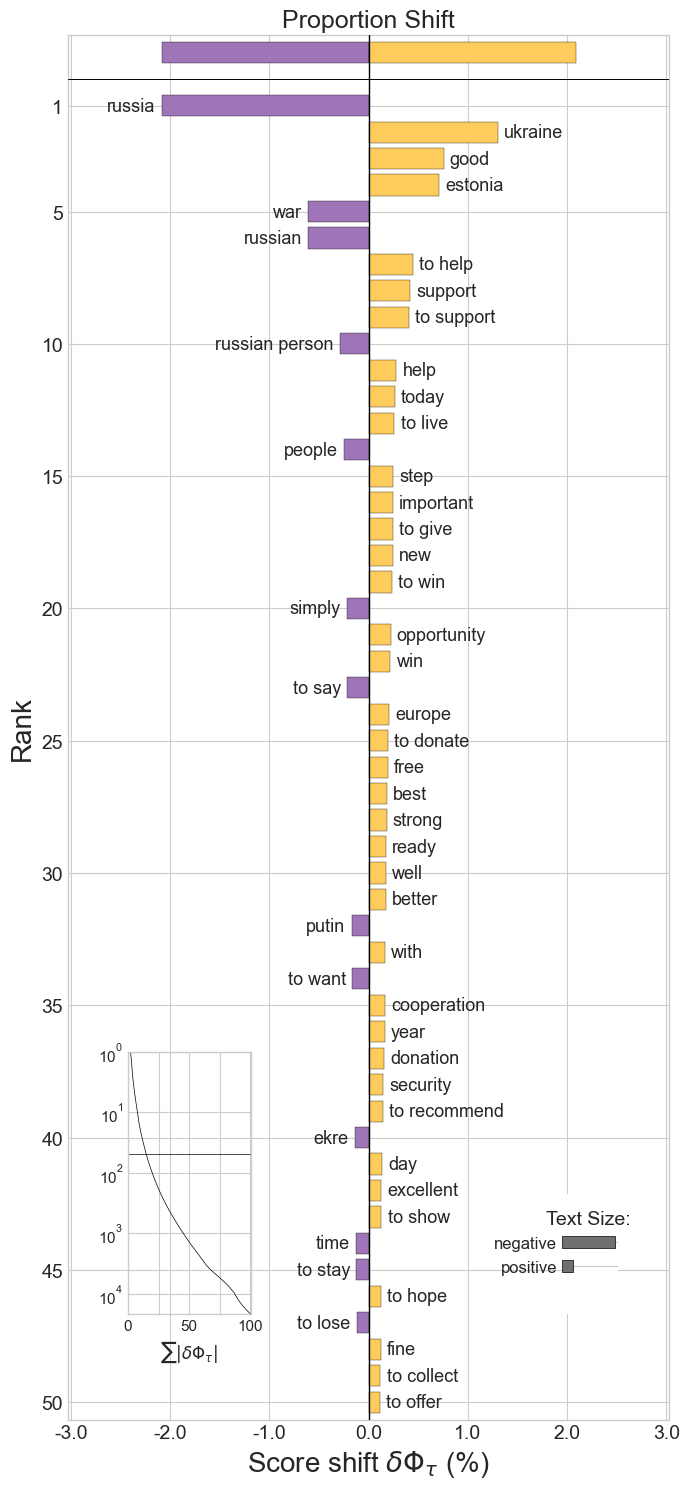

<Axes: title={'center': 'Proportion Shift'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [301]:
# translated words
proportion_shift = sh.ProportionShift(type2freq_1=new_neg,
                                      type2freq_2=new_pos)
proportion_shift.get_shift_graph(system_names = ['negative', 'positive'],
                                 title='Proportion Shift')


C:\Users\lisannal\Anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


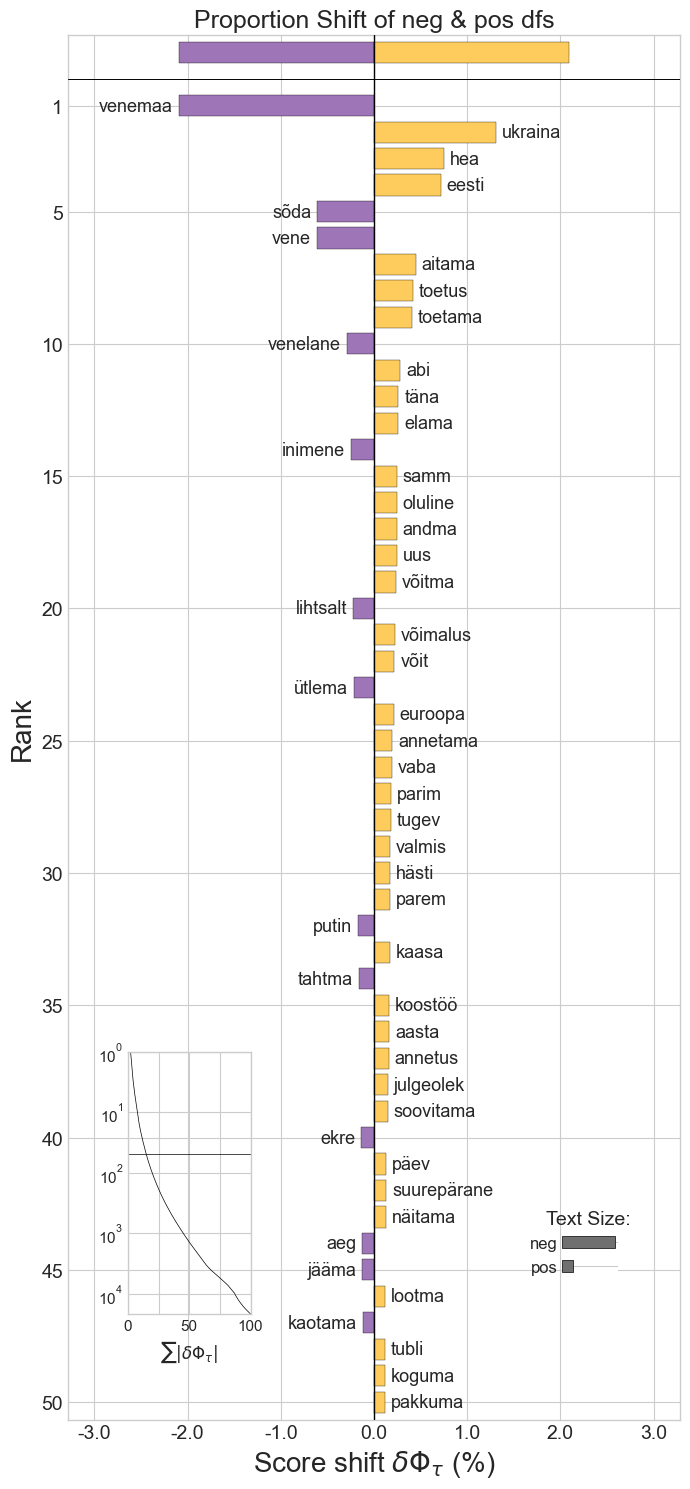

<Axes: title={'center': 'Proportion Shift of neg & pos dfs'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [304]:
# proportion shifts: easy to interpret, simplistic 
# uses relative word frequencies
proportion_shift = sh.ProportionShift(type2freq_1=term_neg,
                                      type2freq_2=term_pos)
proportion_shift.get_shift_graph(system_names = ['neg', 'pos'],
                                 title='Proportion Shift of neg & pos dfs')

## Topics count comparison negative vs positive sentiment datasets

In [63]:
negs_df = sentiments_topics[sentiments_topics['sentiment'] == 'negative']
negs_df['bert_topic_id'].value_counts()[:5]

Russia               2727
Estonia              1752
War                  1443
News/Social Media     549
Combat                404
Name: bert_topic_id, dtype: int64

In [64]:
pos_df = sentiments_topics[sentiments_topics['sentiment'] == 'positive']
pos_df['bert_topic_id'].value_counts()[:5]

Estonia              456
Russia               429
War                  158
Donations             85
News/Social Media     71
Name: bert_topic_id, dtype: int64

## bigrams

In [281]:
#tokenization
filtered = sentiments_topics[(sentiments_topics['bert_topic_id'] == 'Education') & (sentiments_topics['sentiment'] == 'positive')]
#filtered = sentiments_topics[(sentiments_topics['bert_topic_id'] == 'Women')]
texts = filtered['lemma_text']

In [282]:
# Generate ngrams
ngrams = []
for text in texts:
    tokens = nltk.word_tokenize(text.lower())
    ngrams.extend(list(nltk.ngrams(tokens, 2)))

In [283]:
# Count the frequency of each ngram
freq = Counter(ngrams)

# Convert the dictionary of ngram frequencies into a pandas DataFrame
df = pd.DataFrame(list(freq.items()), columns=['ngram', 'frequency'])

# Sort the DataFrame by the frequency column in descending order
df = df.sort_values('frequency', ascending=False)

In [284]:
df[0:20]

,ngram,frequency
39,"(ukraina, keel)",8
3,"(ukraina, laps)",7
61,"(ukraina, sõjapõgenik)",6
65,"(eesti, keel)",5
415,"(vene, keel)",4
455,"(esimene, võõrkeel)",3
115,"(sõjapõgenik, laps)",3
27,"(toetama, ukraina)",3
2,"(tooma, ukraina)",2
594,"(ukraina, õpetaja)",2


## Keyword Analysis

In [588]:
time_data = sentiments_topics.copy()
#time_data['week_interval'] = time_data.groupby(pd.Grouper(key='created_at', freq='W'))['created_at'].transform('first')
time_data['week'] = time_data['created_at'].dt.strftime('%G_%V')
#time_data['week'] = time_data['created_at'].dt.strftime('%U-%Y')
time_data['week'] = pd.Categorical(time_data['week'], categories=time_data['week'].unique().sort(), ordered=True)

In [589]:
time_data['week'].value_counts()

2022_09    1282
2022_08    1216
2022_10     895
2022_11     689
2022_14     615
2022_12     572
2022_19     538
2022_13     462
2022_15     443
2022_41     347
2022_18     347
2022_16     345
2022_38     341
2023_02     339
2023_03     313
2023_01     311
2022_49     301
2022_17     289
2022_39     286
2022_40     280
2022_52     277
2022_46     261
2022_50     260
2022_20     252
2023_04     241
2022_42     238
2022_37     236
2022_51     230
2022_33     230
2022_31     224
2022_21     220
2022_43     218
2022_34     215
2022_47     213
2022_25     209
2022_36     198
2022_32     198
2022_45     197
2022_48     195
2022_30     189
2022_22     187
2022_24     183
2022_07     182
2022_35     179
2022_27     159
2022_29     155
2022_23     151
2022_26     147
2022_28     138
2022_44     126
2023_05     115
2022_06      73
2022_04      65
2022_03      61
2022_05      46
2022_02      33
2022_01      21
2021_52       3
Name: week, dtype: int64

In [606]:
grouped = time_data.groupby('week')

results_df = pd.DataFrame(columns=['week', 'keywords'])

for week, data in grouped:
    tweets = ' '.join(data['lemma_text'].tolist())
    words = tweets.lower().split()
    words = [word.strip('.,!?') for word in words if word.isalpha()]
    words = [word if word != 'genotsiid' else 'sõjakuritegu' for word in words]
    # translate
    words = [word if word != 'sõjakuritegu' else 'war crime' for word in words]
    words = [word if word != 'mobilisatsioon' else 'mobilization' for word in words]
    words = [word if word != 'sanktsioon' else 'sanction' for word in words]
    
    words = [word if word != 'venemaa' else 'Russia' for word in words]
    words = [word if word != 'ukraina' else 'Ukraine' for word in words]
    words = [word if word != 'sõda' else 'war' for word in words]
    
    word_counts = Counter(words)
    top_keywords = word_counts.most_common()
    results_df = results_df.append({'week': week, 'keywords': top_keywords}, ignore_index=True)

C:\Users\lisannal\AppData\Local\Temp\ipykernel_1648\4092952459.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'week': week, 'keywords': top_keywords}, ignore_index=True)
C:\Users\lisannal\AppData\Local\Temp\ipykernel_1648\4092952459.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'week': week, 'keywords': top_keywords}, ignore_index=True)
C:\Users\lisannal\AppData\Local\Temp\ipykernel_1648\4092952459.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'week': week, 'keywords': top_keywords}, ignore_index=True)
C:\Users\lisannal\AppData\Local\Temp\ipykernel_1648\4092952459.py:21: FutureWarning: The frame.append method 

C:\Users\lisannal\AppData\Local\Temp\ipykernel_1648\4092952459.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'week': week, 'keywords': top_keywords}, ignore_index=True)
C:\Users\lisannal\AppData\Local\Temp\ipykernel_1648\4092952459.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'week': week, 'keywords': top_keywords}, ignore_index=True)
C:\Users\lisannal\AppData\Local\Temp\ipykernel_1648\4092952459.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'week': week, 'keywords': top_keywords}, ignore_index=True)
C:\Users\lisannal\AppData\Local\Temp\ipykernel_1648\4092952459.py:21: FutureWarning: The frame.append method 

In [607]:
results_df = results_df.sort_values('week')
results_df = results_df[(results_df['week']!='2021_52')] 

In [608]:
topn_words.sort_values(by='n', ascending=False).head(20)

,word,n
27940,ukraina,10740
29632,venemaa,7553
24432,sõda,2736
3218,eesti,1974
29598,vene,1540
21533,riik,1247
6870,inimene,1053
37,aasta,757
4425,euroopa,746
32199,ütlema,745


In [613]:
results_df

,week,keywords
1,2022_01,"[(Russia, 15), (eesti, 5), (välisminister, 4), (suhe, 3), (varem, 3), (Ukraine, 3), (nõudma, 3), (veok, 3), (maja, 3), (euroopa, 3), (koostöö, 2), (territoriaalne, 2), (terviklikkus, 2), (tulevik, 2), (aasta, 2), (sõber, 2), (jätkama, 2), (hea, 2), (registreerima, 2), (mullu, 2), (nõudmine, 2), (venelane, 2), (liitlane, 2), (pääsema, 2), (raskus, 2), (selge, 2), (astuma, 2), (vene, 2), (julgeolek, 2), (sõbralik, 2), (andma, 2), (raadio, 2), (abi, 2), (oudekk, 2), (kommunist, 2), (kasahstani, 2), (tuumaenergia, 2), (maagaas, 2), (kindlam, 1), (suveräänsus, 1), (tagamine, 1), (kujundama, 1), (euroatlantiline, 1), (kirjutama, 1), (suursaadik, 1), (eestima, 1), (betsa, 1), (sõprus, 1), (tugevam, 1), (sõlmima, 1), (vabariik, 1), (diplomaatiline, 1), (õnnitlema, 1), (kahepoolne, 1), (süvendamine, 1), (rahvas, 1), (hüvang, 1), (oluline, 1), (deeskalatsioon, 1), (toetamine, 1), (piiripunkt, 1), (koidula, 1), (vaatama, 1), (riik, 1), (idapiir, 1), (ületama, 1), (võrdlus, 1), (müncheni, 1), (leping, 1), (ajakohasem, 1), (arvama, 1), (välispoliitika, 1), (instituut, 1), (direktor, 1), (raik, 1), (eestlane, 1), (soomlane, 1), (ukrainlane, 1), (lätlane, 1), (sõbralikult, 1), (pärnuma, 1), (valitsuskoalitsioon, 1), (naaber, 1), (ühine, 1), (praktika, 1), (vormima, 1), (liberaalne, 1), (mõtteviis, 1), (tohtima, 1), (asi, 1), (tühistamiskultuur, 1), (vaade, 1), (kritiseerima, 1), (reetma, 1), (ilmuma, 1), (hüsteeriline, 1), (artikkel, 1), (kahtlustama, 1), (mängima, 1), (ühekülgne, 1), ...]"
2,2022_02,"[(Russia, 36), (Ukraine, 11), (eesti, 9), (lääs, 8), (läbirääkimine, 4), (tariif, 4), (rääkima, 4), (kiiresti, 3), (rahuvalvaja, 3), (eesmärk, 3), (nato, 3), (aitama, 3), (riik, 3), (war, 3), (agressioon, 3), (akadeemik, 3), (hegemoonia, 3), (liikuma, 2), (idaukraina, 2), (aasta, 2), (juuli, 2), (ukrainlane, 2), (ajakirjandus, 2), (kasahstani, 2), (teatama, 2), (arvama, 2), (vägi, 2), (relv, 2), (gruusia, 2), (anastama, 2), (vastav, 2), (olukord, 2), (kollektiivne, 2), (vältima, 2), (säilitama, 2), (julgeolek, 2), (saavutama, 2), (hetk, 2), (euroopa, 2), (venelane, 2), (krimmi, 2), (okupeerimine, 2), (nurjuma, 2), (täielikult, 2), (olema, 2), (probleem, 2), (sanction, 2), (hiina, 2), (tegevus, 2), (suutma, 2), (võimsam, 2), (memorial, 2), (sahharov, 2), (tükk, 2), (nats, 2), (ukrainas, 2), (lõikama, 2), (mariupol, 2), (jälgima, 1), (küberrünnak, 1), (areng, 1), (tähelepanelikult, 1), (teinekord, 1), (nurisema, 1), (reform, 1), (piisavalt, 1), (kiire, 1), (asi, 1), (mandaat, 1), (tulistama, 1), (meeleavaldaja, 1), (eelhoiatamata, 1), (ametlik, 1), (paber, 1), (juhinduma, 1), (täitma, 1), (roll, 1), (astuma, 1), (vabatahtlikult, 1), (nsvli, 1), (koosseis, 1), (laskma, 1), (mustama, 1), (peavoolumeedia, 1), (lärmama, 1), (mõnu, 1), (edastama, 1), (ametnik, 1), (hoiak, 1), (tegemine, 1), (invasioon, 1), (kavatsema, 1), (poliitik, 1), (teenima, 1), (huvi, 1), (järjekindlalt, 1), (kavatsus, 1), (tungima, 1), (ähvardama, 1), (otse, 1), ...]"
3,2022_03,"[(Russia, 59), (Ukraine, 23), (war, 11), (eesti, 7), (tahtma, 7), (täna, 5), (julgeolek, 5), (riik, 5), (mõtlema, 5), (lääs, 5), (valmis, 5), (konflikt, 4), (äkki, 4), (eestlane, 4), (olukord, 4), (putin, 4), (eriti, 4), (venelane, 4), (väitma, 4), (kord, 4), (ütlema, 4), (ukrainlane, 4), (vägi, 4), (lihtsalt, 4), (kasutama, 4), (aasta, 4), (saksamaa, 4), (rikkuma, 4), (ründama, 4), (maailm, 4), (kaks, 3), (valik, 3), (viima, 3), (saatma, 3), (rääkima, 3), (euroopa, 3), (piir, 3), (valitsus, 3), (miljon, 3), (päev, 3), (palju, 3), (lööma, 3), (probleem, 3), (hiina, 3), (soovitama, 3), (veneukraina, 3), (vandenõuteooria, 3), (endine, 3), (diplomaatia, 2), (rahu, 2), (suurem, 2), (agressioon, 2), (berliini, 2), (mängima, 2), (konkreetselt, 2), (teadma, 2), (inimene, 2), (kaitsma, 2), (jätma, 2), (aeg, 2), (valima, 2), (vaja, 2), (lääneriik, 2), (üldse, 2), (nats, 2), (elu, 2), (blinken, 2), (kõne, 2), (piirama, 2), (senine, 2), (nägema, 2), (tuumarelv, 2), (uskuma, 2), (territoor

In [616]:
# counts for the keyword "xxx"
ukraina_counts = []
for i, row in results_df.iterrows():
    week = row['week']
    keywords = dict(row['keywords'])
    ukraina_count = keywords.get('sanction', 0)
    ukraina_counts.append((week, ukraina_count))


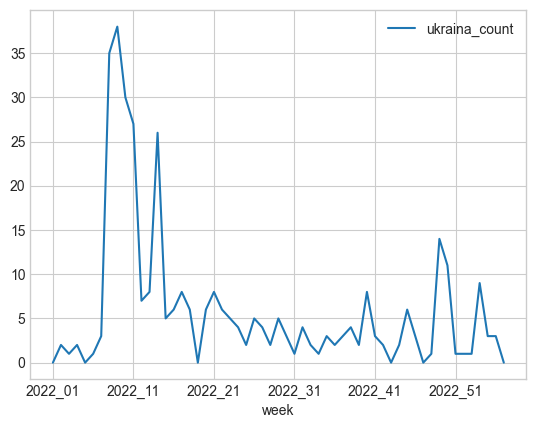

In [617]:
ukraina_df = pd.DataFrame(ukraina_counts, columns=['week', 'ukraina_count'])
ukraina_df.plot(x='week', y='ukraina_count', kind='line')
#plt.xticks(rotation=70)
plt.show()

In [618]:
def get_keyword_counts(df, keyword_list):
    counts = [[] for _ in range(len(keyword_list))]
    
    for i, row in df.iterrows():
        week = row['week']
        keywords = dict(row['keywords'])
        
        for j, keyword in enumerate(keyword_list):
            keyword_counts = keywords.get(keyword, 0)
            counts[j].append((week, keyword_counts))
    
    return counts

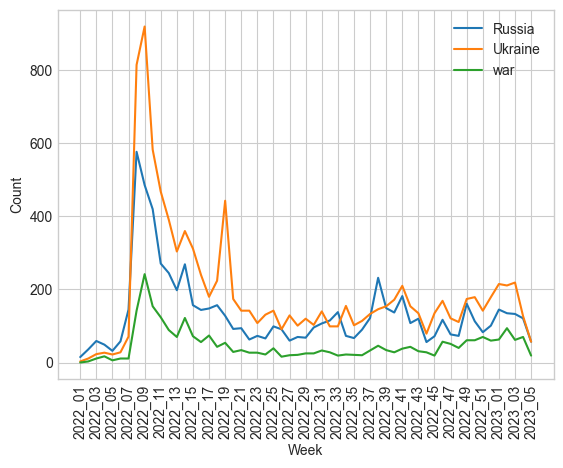

In [626]:
keywords = ['Russia', 'Ukraine','war']
counts = get_keyword_counts(results_df, keywords)

for i, keyword in enumerate(keywords):
    plt.plot([c[0] for c in counts[i]], [c[1] for c in counts[i]], label=keyword)

plt.legend()
plt.xlabel("Week")
plt.ylabel("Count")
plt.xticks(range(0, len(ukraina_counts), 2), [x[0] for i, x in enumerate(ukraina_counts) if i%2==0], rotation=90)
#plt.axvline(x=18, color='red')  # Add vertical line
#plt.axvline(x=37, color='red')  


plt.savefig('public_keywords_2', facecolor=fig.get_facecolor(), bbox_inches='tight')


plt.show()

# mariupol siege ends 20, ukraina
# 39, venemaa, mobilization starts

In [564]:
# butcha, 2022_13
# moskova sinking, 2022_15
# siege of mariupol ends, 2022_20/21
# russia mobilization, 2022_38
# crime bridge attack, 2022_40

In [554]:
results_df.iloc[[0]]

,week,keywords
1,2022_01,"[(venemaa, 15), (eesti, 5), (välisminister, 4), (suhe, 3), (varem, 3), (ukraina, 3), (nõudma, 3), (veok, 3), (maja, 3), (euroopa, 3), (koostöö, 2), (territoriaalne, 2), (terviklikkus, 2), (tulevik, 2), (aasta, 2), (sõber, 2), (jätkama, 2), (hea, 2), (registreerima, 2), (mullu, 2), (nõudmine, 2), (venelane, 2), (liitlane, 2), (pääsema, 2), (raskus, 2), (selge, 2), (astuma, 2), (vene, 2), (julgeolek, 2), (sõbralik, 2), (andma, 2), (raadio, 2), (abi, 2), (oudekk, 2), (kommunist, 2), (kasahstani, 2), (tuumaenergia, 2), (maagaas, 2), (kindlam, 1), (suveräänsus, 1), (tagamine, 1), (kujundama, 1), (euroatlantiline, 1), (kirjutama, 1), (suursaadik, 1), (eestima, 1), (betsa, 1), (sõprus, 1), (tugevam, 1), (sõlmima, 1), (vabariik, 1), (diplomaatiline, 1), (õnnitlema, 1), (kahepoolne, 1), (süvendamine, 1), (rahvas, 1), (hüvang, 1), (oluline, 1), (deeskalatsioon, 1), (toetamine, 1), (piiripunkt, 1), (koidula, 1), (vaatama, 1), (riik, 1), (idapiir, 1), (ületama, 1), (võrdlus, 1), (müncheni, 1), (leping, 1), (ajakohasem, 1), (arvama, 1), (välispoliitika, 1), (instituut, 1), (direktor, 1), (raik, 1), (eestlane, 1), (soomlane, 1), (ukrainlane, 1), (lätlane, 1), (sõbralikult, 1), (pärnuma, 1), (valitsuskoalitsioon, 1), (naaber, 1), (ühine, 1), (praktika, 1), (vormima, 1), (liberaalne, 1), (mõtteviis, 1), (tohtima, 1), (asi, 1), (tühistamiskultuur, 1), (vaade, 1), (kritiseerima, 1), (reetma, 1), (ilmuma, 1), (hüsteeriline, 1), (artikkel, 1), (kahtlustama, 1), (mängima, 1), (ühekülgne, 1), ...]"


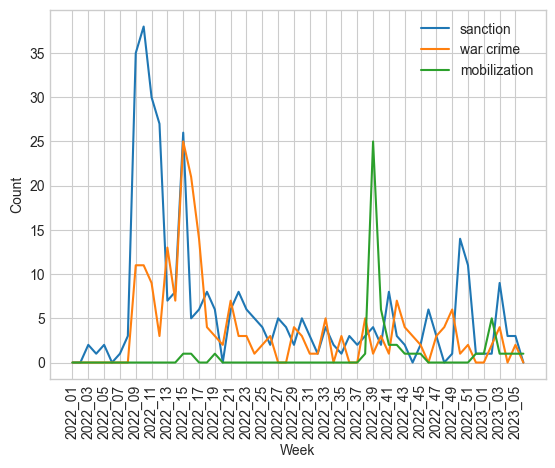

In [566]:
keywords = ['sanction', 'war crime','mobilization']
counts = get_keyword_counts(results_df, keywords)

for i, keyword in enumerate(keywords):
    plt.plot([c[0] for c in counts[i]], [c[1] for c in counts[i]], label=keyword)

plt.legend()
plt.xlabel("Week")
plt.ylabel("Count")
plt.xticks(range(0, len(ukraina_counts), 2), [x[0] for i, x in enumerate(ukraina_counts) if i%2==0], rotation=90)

plt.savefig('public_keywords', facecolor=fig.get_facecolor(), bbox_inches='tight')


plt.show()

# butcha 13 war crime x sanctions
# 50 sanctions

## Public vs Leaders wordshift

In [508]:
leaders = pd.read_excel('../leaders_analysis/sentiments_topics.xlsx')

In [509]:
print('leaders', len(leaders))
print('public', len(sentiments_topics))

leaders 3223
public 16736


In [514]:
# get terms and counts
term_leaders = create_term_matrix(leaders).sort_values(ascending=False)
term_public = create_term_matrix(sentiments_topics).sort_values(ascending=False)

# pandas series to to dict
from collections import OrderedDict, defaultdict

term_leaders = term_leaders.to_dict()
term_public = term_public.to_dict()

In [516]:
print('leaders', len(term_leaders))
print('public', len(term_public))

leaders 24874
public 32333


In [577]:
my_dict = {
    "vene": "russian",
    "eesti": "estonia",
    "venemaa": "russia",
    "ukraina": "ukraine",
    "sõda": "war",
    "lääs": "west",
    "lihtsalt": "simply",
    "asi": "thing",
    "keel": "language",
    "tahtma":"to want",
    "ütlema": "to say",
    "arvama":"to think",
    "lipp":"flag",
    "mees": "man",
    "putin":"putin",
    "sõdur": "soldier",
    "aasta": "year",
    "riik":"country",
    "riigikogu":"Riigikogu",
    "valitsus":"government",
    "liit":"union",
    "täna": "today",
    "inimene": "people",
     "oluline": "important",
    "koostöö": "cooperation",
    "euroopa": "europe",
    "venelane": "russian person",
    "parlament":"parliament",
    "lihsalt":"simply",
    "julgeolek":"security",
    "isamaa":"Isamaa",
    "asi": "thing",
    "erakond": "political party",
    "keel": "language",
    "koostöö": "cooperation",
    "tahtma": "to want",
    "reformierakond": "Reform party",
    "otsus": "decision",
    "ütlema": "to say",
    "eest": "for",
    "liige": "member",
    "riigikaitse": "national defence",
    "kohtumine": "meeting",
    "liitlane": "ally",
    "euro": "euro",
    "arvama": "opinion",
    "lipp": "flag",
    "mees": "man",
    "olukord": "situation",
    "putin": "putin",
    "sõdur": "soldier",
    "sõjaline": "millitary",
    "valimine": "elections",
    "tagama": "to ensure",
    "kohtuma": "to meet",
    "esimees": "chairman",
    "peaminister": "prime minister",
    "lähemalt": "closer",
    "tänane": "todays",
    "rahvusvaheline": "international",
    "uudis": "news",
    "ühiskond": "society"
}

In [578]:
new_leaders = {}

for key in term_leaders:
    current_value = term_leaders[key]
    new_key = key
    if key in my_dict:
        new_key = my_dict[key]
    if new_key in new_leaders:
        current_value = current_value + new_leaders[new_key]
    new_leaders[new_key] = current_value

In [579]:
new_public= {}

for key in list(term_public.keys()):
    current_value = term_public[key]
    new_key = key
    if key in my_dict:
        new_key = my_dict[key]
    if new_key in new_public:
        current_value = current_value + new_public[new_key]
    new_public[new_key] = current_value

In [580]:
new_leaders = dict(sorted(new_leaders.items(), key=lambda item: item[1], reverse=True))
new_public = dict(sorted(new_public.items(), key=lambda item: item[1], reverse=True))

C:\Users\lisannal\Anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


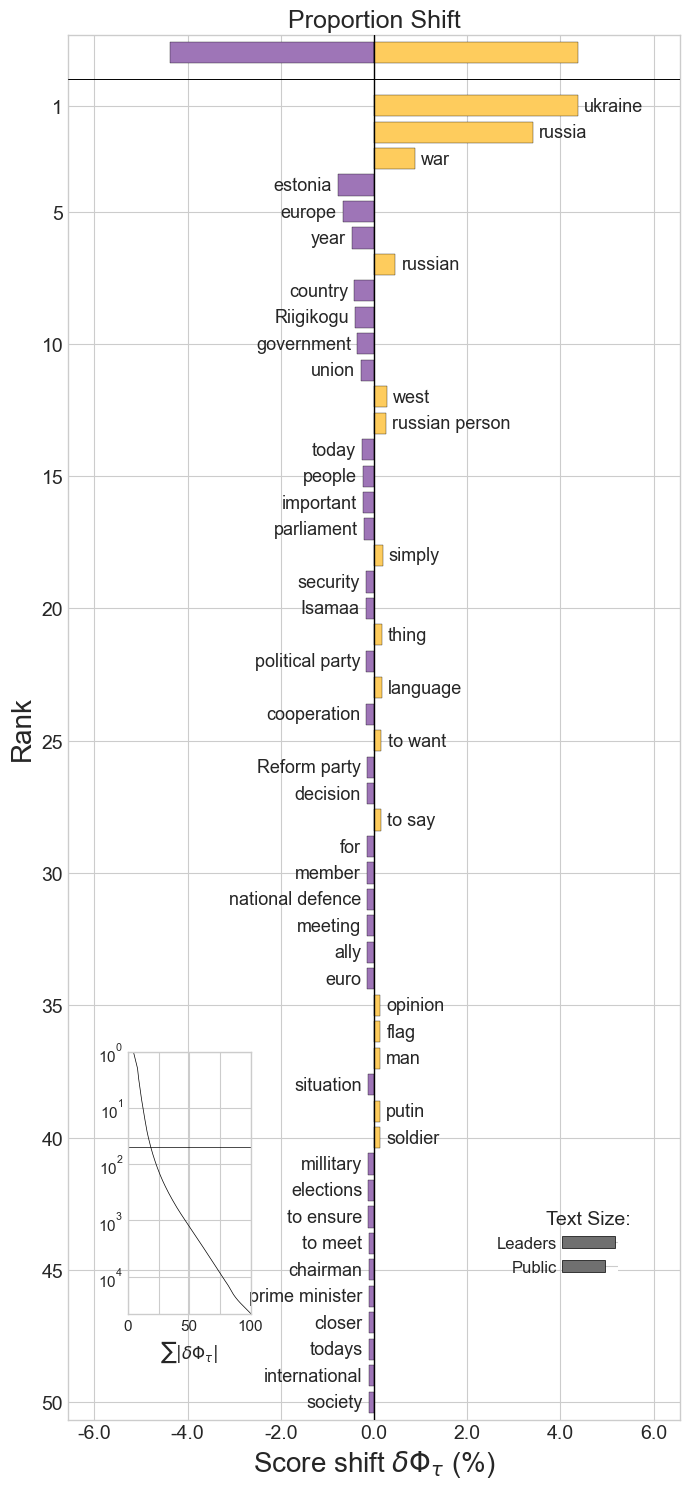

<Axes: title={'center': 'Proportion Shift'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [581]:
# translated words
proportion_shift = sh.ProportionShift(type2freq_1=new_leaders,
                                      type2freq_2=new_public)
proportion_shift.get_shift_graph(system_names = ['Leaders', 'Public'],
                                 title='Proportion Shift')

C:\Users\lisannal\Anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


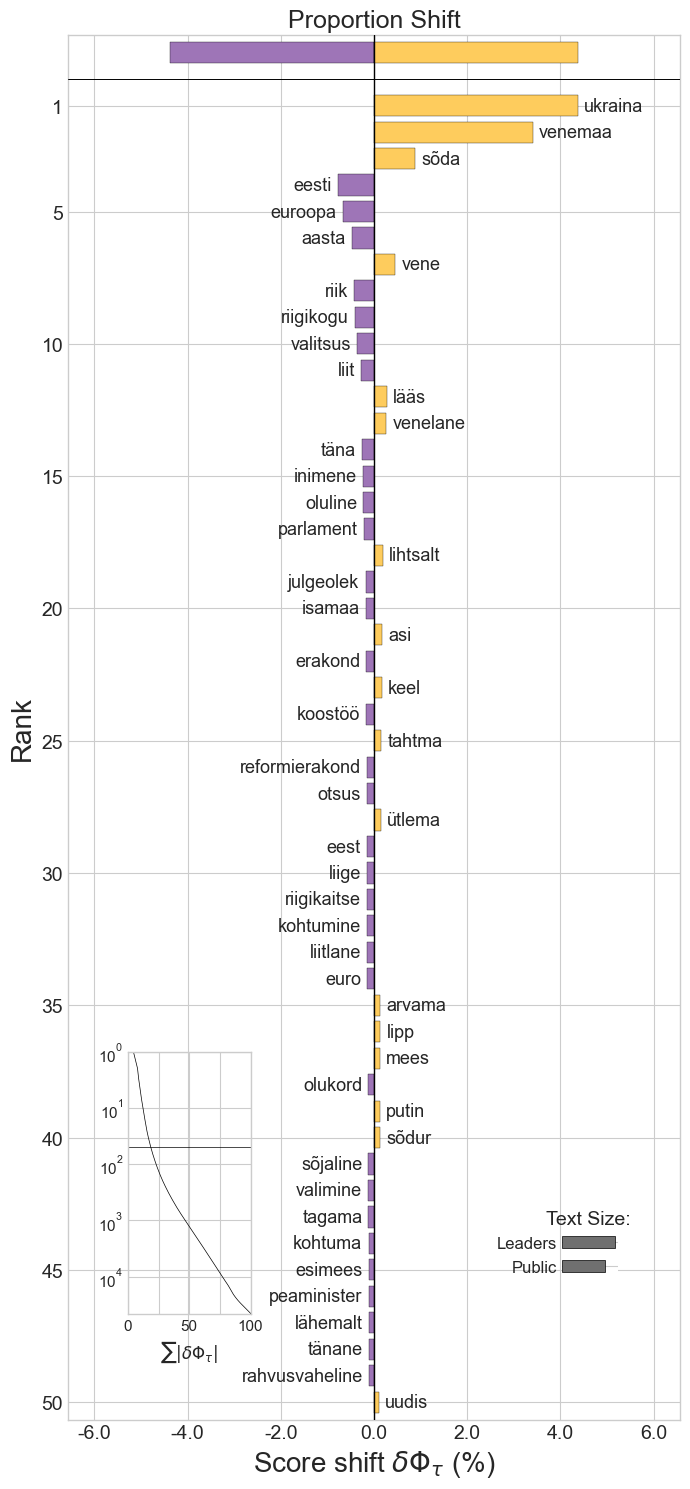

<Axes: title={'center': 'Proportion Shift'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [515]:
# proportion shifts: easy to interpret, simplistic 
# uses relative word frequencies
proportion_shift = sh.ProportionShift(type2freq_1=term_leaders,
                                      type2freq_2=term_public)
proportion_shift.get_shift_graph(system_names = ['Leaders', 'Public'],
                                 title='Proportion Shift')

## WordCloud

In [658]:
def create_term_matrix(in_data):
    cv = CountVectorizer(analyzer = 'word')
    data = cv.fit_transform(in_data['lemma_text'])
    tm_matrix = pd.DataFrame(data.toarray(), columns = cv.get_feature_names_out())
    tm_matrix.index = in_data.index
    return tm_matrix.sum().transpose()

C:\Users\lisannal\AppData\Local\Temp\ipykernel_1648\2029942951.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread('ukr.png', pilmode='RGBA')


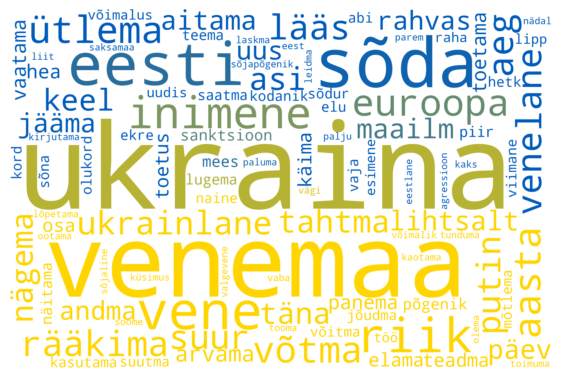

In [660]:
from wordcloud import WordCloud
import imageio

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# Combine all texts into a single string
combined_text = ' '.join(sentiments_topics['lemma_text'].tolist())
term_data = create_term_matrix(sentiments_topics).sort_values(ascending=False)
# Generate a word cloud image
mask = np.array(Image.open("ukr.png"))
im = imageio.imread('ukr.png', pilmode='RGBA')
wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=100, mask=im).generate_from_frequencies(term_data)

image_colors = ImageColorGenerator(im)
print(image_colors)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')
plt.savefig("wordcloud.png")

plt.show()